In [1]:
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
import torch.backends.cudnn as cudnn
import matplotlib.pyplot as plt
import torch.utils.data as Data
import matplotlib as mpl
import scipy.io as sio
import numpy as np
import argparse
import time

import torch
import torch.nn as nn
from torch import optim
import torch.utils.data as Data
import torch.nn.functional as F
from torchsummary import summary
import torch.backends.cudnn as cudnn
from sklearn.metrics import confusion_matrix


from data_prepare import mirror_hsi
from Utils import ActivationOutputData, safe_norm
from caps_vit import CapsViT, Margin_Recon_Loss
from data_prepare import choose_train_and_test_number
from Utils import output_metric, plot_confusion_matrix
from Utils import train_epoch, test_epoch, valid_epoch
from data_prepare import choose_train_and_test_proportion
from Utils import list_to_colormap, classification_map, print_args
from data_prepare import train_and_test_data, train_and_test_label


%matplotlib inline

In [2]:
parser = argparse.ArgumentParser("Caps-Transformer")
parser.add_argument('--dataset', choices=['Indian', 'Pavia', 'KSC'], default='KSC', help='dataset to use')
parser.add_argument('--flag_test', choices=['test', 'train'], default='train', help='testing mark')
parser.add_argument('--mode', choices=['ViT', 'CAF'], default='CAF', help='mode choice')
parser.add_argument('--gpu_id', default='0', help='GPU id')
parser.add_argument('--seed', type=int, default=0, help='number of seed')
parser.add_argument('--batch_size', type=int, default=32, help='number of batch size')
parser.add_argument('--patch_size', type=int, default=7, help='size of patches')
parser.add_argument('--epoches', type=int, default=200, help='epoch number')
parser.add_argument('--learning_rate', type=float, default=5e-4, help='learning rate')
parser.add_argument('--gamma', type=float, default=0.99, help='gamma')
parser.add_argument('--weight_decay', type=float, default=0.001, help='weight_decay')
parser.add_argument('--train_number', type=int, default=1, help='num_train_per_class')
parser.add_argument('--train_proportion', type=float, default=0.1, help='num_train_per_class')
args = parser.parse_args(args=[])

In [3]:
# 设置torch.random和torch.cuda.random随机种子，使模型的各种参数初始化以及DataLoader在生成随机小批量时在每次实验过程中
# 均保持一致，以保证每次运行的实验结果尽量保持相同

torch.manual_seed(args.seed)
torch.cuda.manual_seed(args.seed)
cudnn.deterministic = True
cudnn.benchmark = False

In [4]:
# prepare data
if args.dataset == 'Indian':
    data = sio.loadmat('./dataset/Indian_pines_corrected.mat')['indian_pines_corrected']
    label = sio.loadmat('./dataset/Indian_pines_gt.mat')['indian_pines_gt']
elif args.dataset == 'Pavia':
    data = sio.loadmat('./dataset/PaviaU.mat')['paviaU']
    label = sio.loadmat('./dataset/PaviaU_gt.mat')['paviaU_gt']
elif args.dataset == 'KSC':
    data = sio.loadmat('./dataset/KSC.mat')['KSC']
    label = sio.loadmat('./dataset/KSC_gt.mat')['KSC_gt']
else:
    raise ValueError("Unknown dataset")
    
num_classes = np.max(label)
print('The class numbers of the HSI data is:', num_classes)

The class numbers of the HSI data is: 13


In [5]:
shapeor = data.shape
data = data.reshape(np.prod(data.shape[:2]), np.prod(data.shape[2:]))

std_scaler = StandardScaler()
std_data = std_scaler.fit_transform(data)
data = std_data.reshape(shapeor)

In [6]:
total_pos_train, total_pos_test, total_pos_true, number_train, number_test, number_true = \
choose_train_and_test_number(label, args.train_number, seed=args.seed)

# data size
height, width, band = data.shape
print("height={0}, width={1}, band={2}".format(height, width, band))

height=512, width=614, band=176


In [7]:
mirror_data = mirror_hsi(height, width, band, data, patch_size=args.patch_size)

x_train, x_test, x_true = train_and_test_data(mirror_data, band, total_pos_train, total_pos_test, 
                                              total_pos_true, patch_size=args.patch_size)

**************************************************
patch_size is : 7
mirror_data shape : [518, 620, 176]
**************************************************
x_train shape = (13, 7, 7, 176), type = float64
x_test  shape = (5198, 7, 7, 176), type = float64
x_true  shape = (5211, 7, 7, 176), type = float64
**************************************************


In [8]:
y_train, y_test, y_true = train_and_test_label(number_train, number_test, number_true, num_classes)

# load data
x_train = torch.from_numpy(x_train.transpose(0, 3, 1, 2)).type(torch.FloatTensor)  # (13, 176, 7, 7)
print(x_train.shape)
y_train = torch.from_numpy(y_train).type(torch.LongTensor)  # (13,)
Train_Label = Data.TensorDataset(x_train, y_train)

x_test = torch.from_numpy(x_test.transpose(0, 3, 1, 2)).type(torch.FloatTensor)  # (5198, 176, 7, 7)
print(x_test.shape)
y_test = torch.from_numpy(y_test).type(torch.LongTensor)  # (5198,)
Test_Label = Data.TensorDataset(x_test, y_test)

x_true = torch.from_numpy(x_true.transpose(0, 3, 1, 2)).type(torch.FloatTensor)  # (5211, 176, 7, 7)
print(x_true.shape)
y_true = torch.from_numpy(y_true).type(torch.LongTensor)
True_Label = Data.TensorDataset(x_true, y_true)

train_loader = Data.DataLoader(Train_Label, batch_size=args.batch_size, shuffle=True)
test_loader = Data.DataLoader(Test_Label, batch_size=args.batch_size, shuffle=False)
true_loader = Data.DataLoader(True_Label, batch_size=100, shuffle=False)

y_train: shape = (13,), type = int64
y_test: shape = (5198,), type = int64
y_true: shape = (5211,), type = int64
**************************************************
torch.Size([13, 176, 7, 7])
torch.Size([5198, 176, 7, 7])
torch.Size([5211, 176, 7, 7])


In [9]:
model = CapsViT(band, args.patch_size, preliminary_layer_channels=96, mode=args.mode, caps2_caps=num_classes)

model = model.cuda()
# criterion
criterion = Margin_Recon_Loss()
# optimizer
optimizer = optim.Adam(model.parameters(), lr=args.learning_rate, weight_decay=args.weight_decay)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=args.gamma)
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=args.epoches//10, gamma=args.gamma)

In [10]:
print('start training')
# train model
model.train()
tic = time.time()
for epoch in range(args.epoches):
    # 计算的是移动平均准确率
    train_acc, train_obj, tar_train, pre_train = train_epoch(model, train_loader, criterion, optimizer)
    OA_trian, AA_mean_train, Kappa_train, AA_train = output_metric(tar_train, pre_train)
    print("Epoch: {:03d} train_loss: {:.4f} train_acc: {:.4f}".format(epoch+1, train_obj, train_acc))
    scheduler.step()

toc = time.time()
if args.mode == 'ViT':
    torch.save(model.state_dict(), './models/CapsViT.pt')
elif (args.mode == 'CAF'):
    torch.save(model.state_dict(), './models/CapsCAF.pt')
print("Running Time: {:.2f}".format(toc-tic))
print("**************************************************")

start training
Epoch: 001 train_loss: 0.8094 train_acc: 23.0769
Epoch: 002 train_loss: 0.7771 train_acc: 7.6923
Epoch: 003 train_loss: 0.7079 train_acc: 23.0769
Epoch: 004 train_loss: 0.6110 train_acc: 23.0769
Epoch: 005 train_loss: 0.5483 train_acc: 30.7692
Epoch: 006 train_loss: 0.5658 train_acc: 23.0769
Epoch: 007 train_loss: 0.5917 train_acc: 69.2308
Epoch: 008 train_loss: 0.5847 train_acc: 7.6923
Epoch: 009 train_loss: 0.5565 train_acc: 7.6923
Epoch: 010 train_loss: 0.5374 train_acc: 7.6923
Epoch: 011 train_loss: 0.5458 train_acc: 7.6923
Epoch: 012 train_loss: 0.5551 train_acc: 15.3846
Epoch: 013 train_loss: 0.5518 train_acc: 61.5385
Epoch: 014 train_loss: 0.5410 train_acc: 53.8462
Epoch: 015 train_loss: 0.5294 train_acc: 46.1538
Epoch: 016 train_loss: 0.5208 train_acc: 53.8462
Epoch: 017 train_loss: 0.5182 train_acc: 53.8462
Epoch: 018 train_loss: 0.5165 train_acc: 61.5385
Epoch: 019 train_loss: 0.5102 train_acc: 76.9231
Epoch: 020 train_loss: 0.5040 train_acc: 84.6154
Epoch: 021

Epoch: 166 train_loss: 0.0124 train_acc: 100.0000
Epoch: 167 train_loss: 0.0119 train_acc: 100.0000
Epoch: 168 train_loss: 0.0113 train_acc: 100.0000
Epoch: 169 train_loss: 0.0116 train_acc: 100.0000
Epoch: 170 train_loss: 0.0123 train_acc: 100.0000
Epoch: 171 train_loss: 0.0116 train_acc: 100.0000
Epoch: 172 train_loss: 0.0114 train_acc: 100.0000
Epoch: 173 train_loss: 0.0115 train_acc: 100.0000
Epoch: 174 train_loss: 0.0116 train_acc: 100.0000
Epoch: 175 train_loss: 0.0123 train_acc: 100.0000
Epoch: 176 train_loss: 0.0109 train_acc: 100.0000
Epoch: 177 train_loss: 0.0112 train_acc: 100.0000
Epoch: 178 train_loss: 0.0127 train_acc: 100.0000
Epoch: 179 train_loss: 0.0115 train_acc: 100.0000
Epoch: 180 train_loss: 0.0115 train_acc: 100.0000
Epoch: 181 train_loss: 0.0109 train_acc: 100.0000
Epoch: 182 train_loss: 0.0104 train_acc: 100.0000
Epoch: 183 train_loss: 0.0104 train_acc: 100.0000
Epoch: 184 train_loss: 0.0116 train_acc: 100.0000
Epoch: 185 train_loss: 0.0112 train_acc: 100.0000


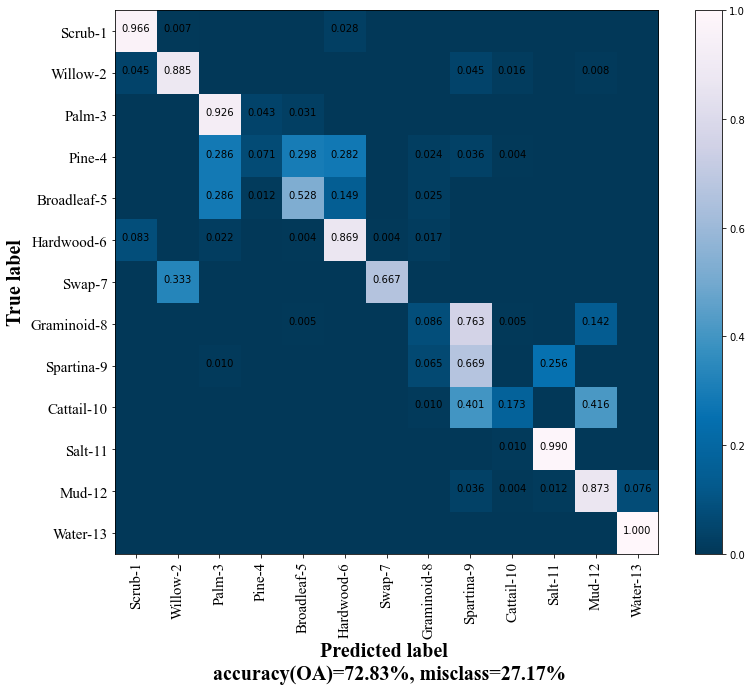

**************************************************
Final result:
OA: 72.76% | AA: 66.82% | Kappa: 0.70
[0.96578947 0.88429752 0.9254902  0.06772908 0.525      0.86842105
 0.66346154 0.08372093 0.66859345 0.17121588 0.99043062 0.87250996
 1.        ]
**************************************************
Parameter:
dataset: KSC
flag_test: train
mode: CAF
gpu_id: 0
seed: 0
batch_size: 32
patch_size: 7
epoches: 200
learning_rate: 0.0005
gamma: 0.99
weight_decay: 0.001
train_number: 1
train_proportion: 0.1
**************************************************


In [11]:
if args.mode == 'ViT':
    model.load_state_dict(torch.load('./models/CapsViT.pt'))
elif (args.mode == 'CAF'):
    model.load_state_dict(torch.load('./models/CapsCAF.pt'))
else:
    raise ValueError("Wrong Parameters")
model.eval()
tar_test, pre_test = test_epoch(model, test_loader)  # 收集所有真实标签和预测标签(np.array)
OA_test, AA_mean_test, Kappa_test, AA_test = output_metric(tar_test, pre_test)

# output classification maps
pre_u = valid_epoch(model, true_loader)
prediction_matrix = np.zeros((height, width), dtype=float)  # (512, 614)
for i in range(total_pos_true.shape[0]):
    prediction_matrix[total_pos_true[i, 0], total_pos_true[i, 1]] = pre_u[i] + 1
cm = confusion_matrix(y_true, pre_u)
plot_confusion_matrix(args.dataset, cm, path='./Confusion_Map_CapsCAF.pdf')



print("**************************************************")
print("Final result:")
print("OA: {:.2f}% | AA: {:.2f}% | Kappa: {:.2f}".format(OA_test * 100., AA_mean_test*100., Kappa_test))
print(AA_test)
print("**************************************************")
print("Parameter:")
print_args(vars(args))
print("**************************************************")

In [12]:
#predict_map = list_to_colormap(prediction_matrix.ravel())
#predict_map = np.reshape(predict_map, (height, width, 3))

#true_map = list_to_colormap(label.ravel())
#true_map = np.reshape(true_map, (height, width, 3))
#classification_map(true_map, './GT.pdf')
#classification_map(predict_map, './Predict_Map.pdf')

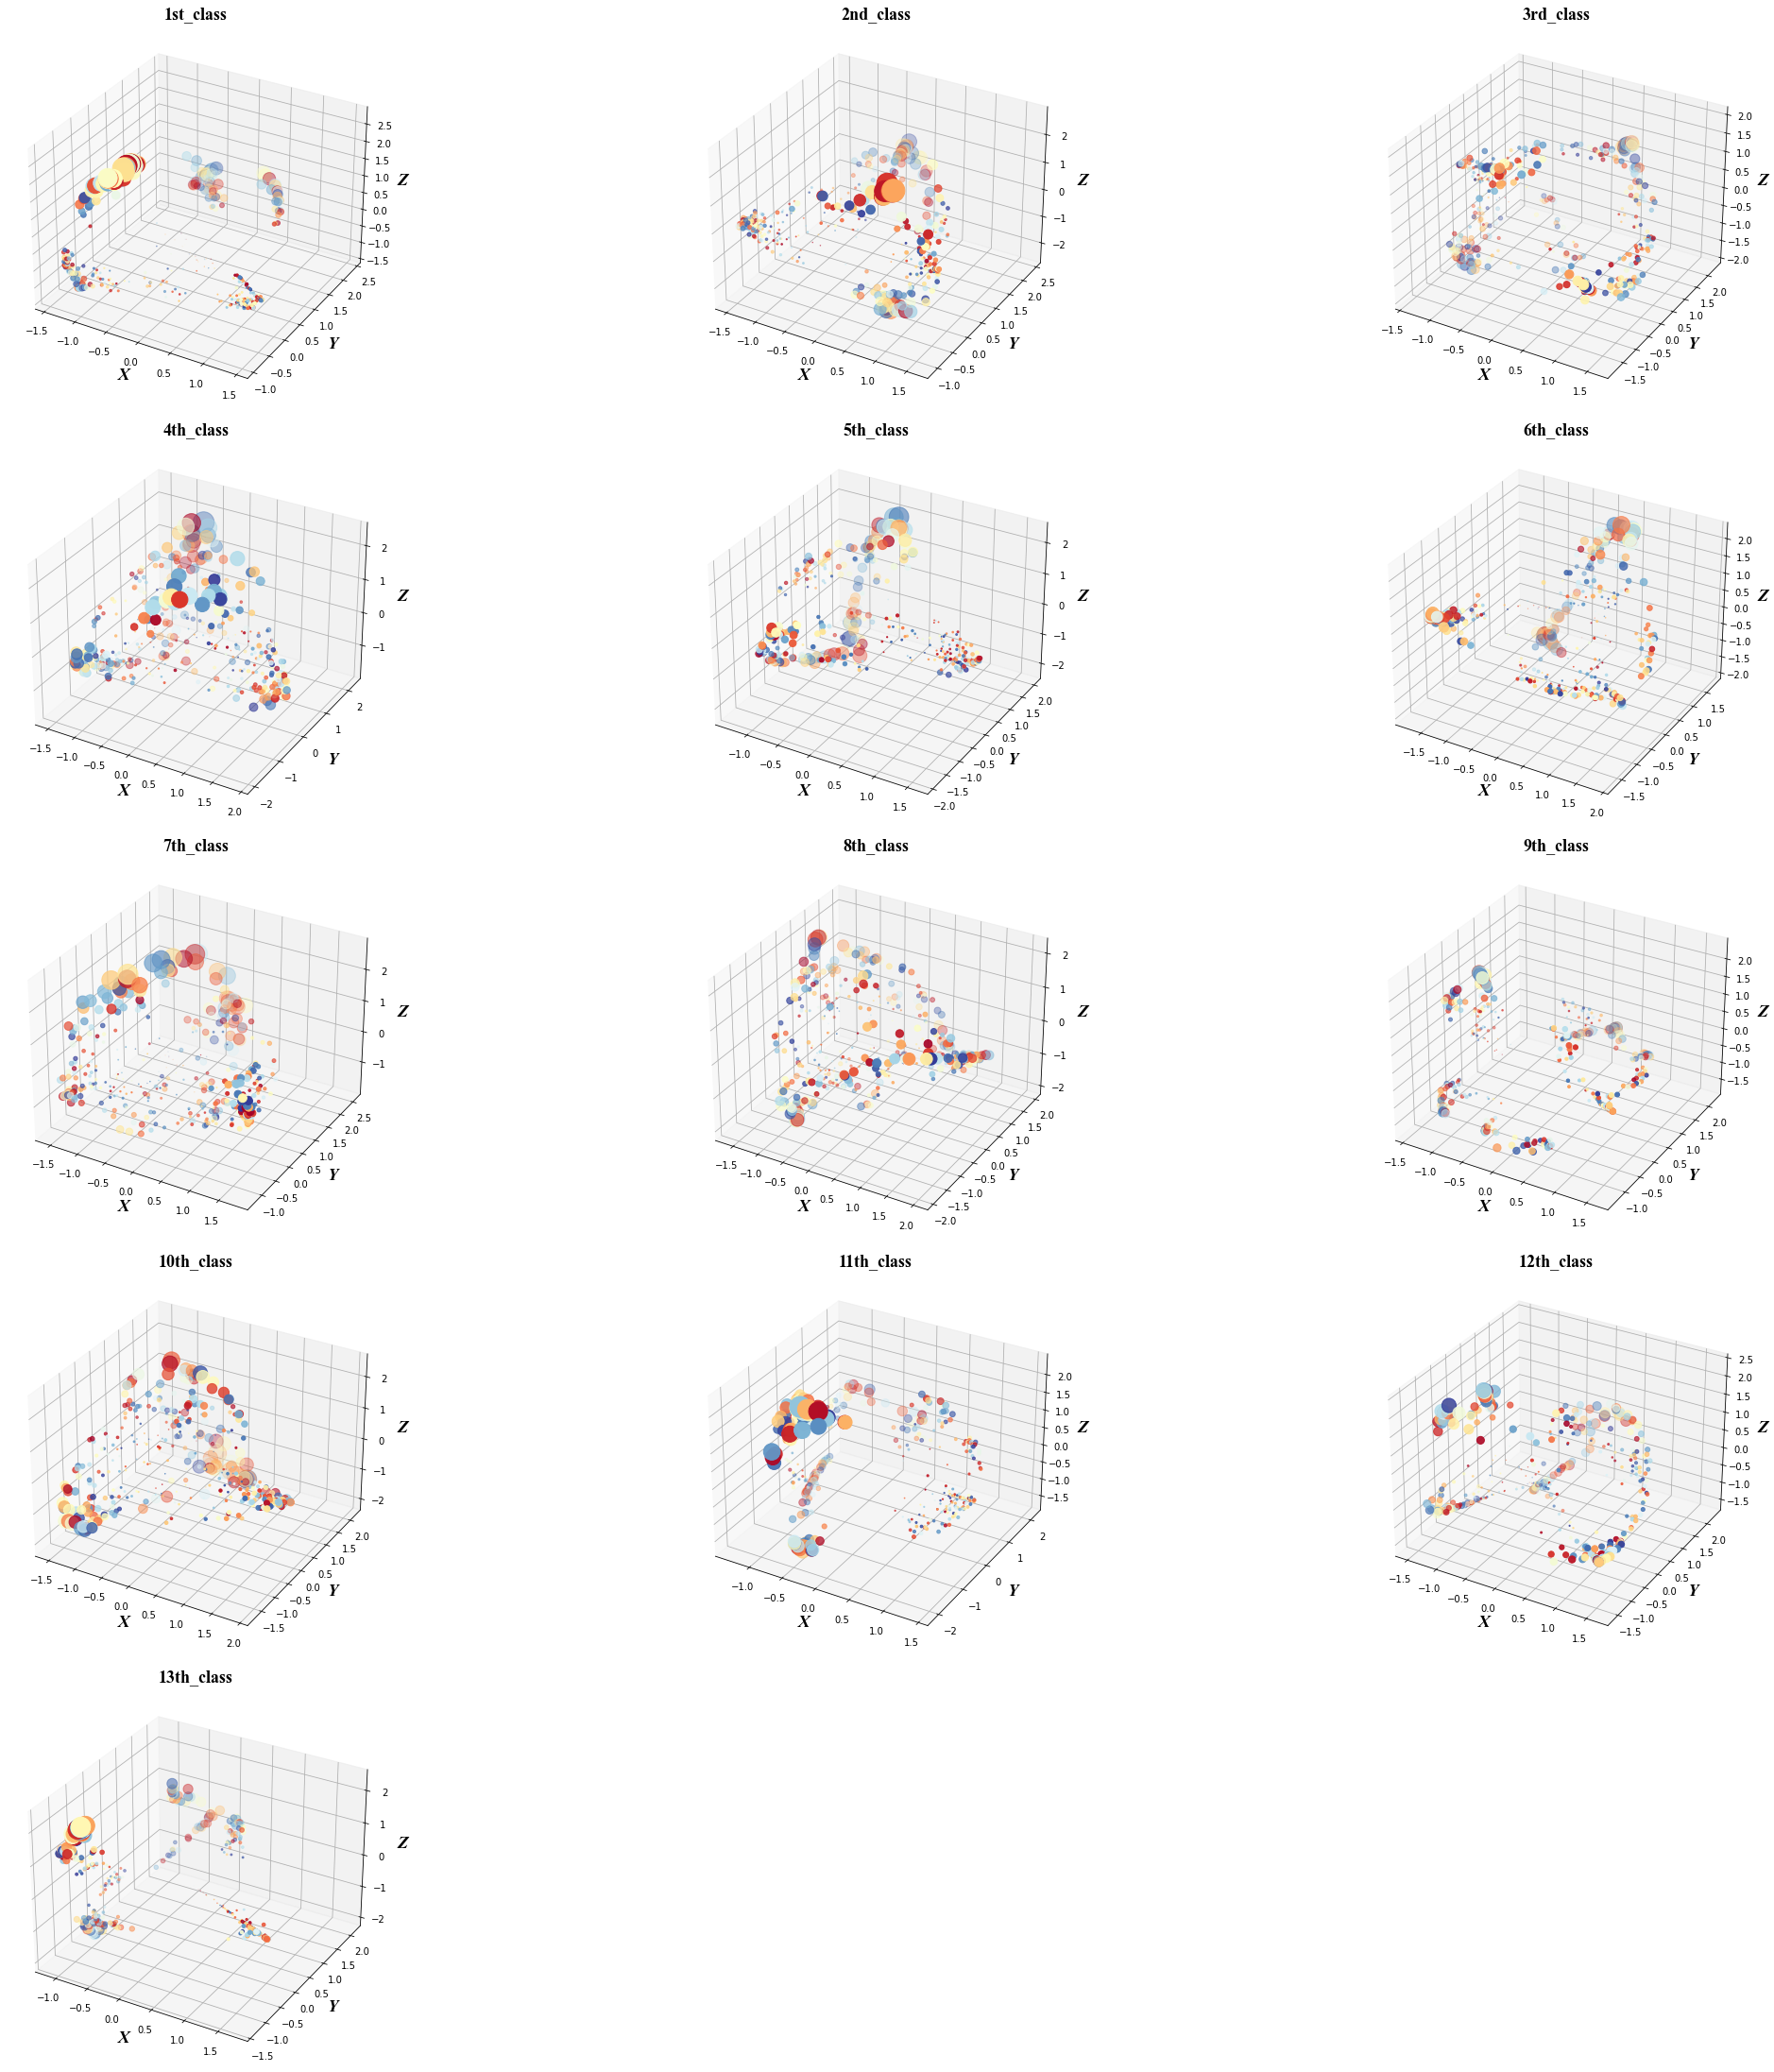

In [13]:
primary_caps_out = ActivationOutputData(model.primary_caps)  # (1, 400, 8)
# 传入测试样本
output, _ = model(x_train.cuda())
primary_caps_out.remove()

font_style = dict(family='Times New Roman', style='italic', size=18, weight='black')
title_style = dict(family='Times New Roman', size=18, weight='black')
fig = plt.figure(figsize=(30, 30))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.1, wspace=0.)
pca = PCA(n_components=3, whiten=True)
for i in range(num_classes):
    outputs = pca.fit_transform(primary_caps_out.outputs[i].detach().numpy())
    ax = fig.add_subplot(5, 3, i+1, projection='3d')
    x = outputs[:, 0]
    y = outputs[:, 1]
    z = outputs[:, 2]
    ax.scatter(x, y, z, s=np.power(np.sqrt(x**2+y**2+z**2), 6), c=np.random.rand(400), cmap=mpl.cm.RdYlBu)
    ax.set_xlabel('X', **font_style)
    ax.set_ylabel('Y', **font_style)
    ax.set_zlabel('Z', **font_style)
    if i == 0:
        plt.title('{}st_class'.format(i+1), **title_style)
    elif i == 1:
        plt.title('{}nd_class'.format(i+1), **title_style)
    elif i == 2:
        plt.title('{}rd_class'.format(i+1), **title_style)
    else:
        plt.title('{}th_class'.format(i+1), **title_style)
        
plt.show()        
fig.savefig('./Caps1_Outputs/primary_caps_outputs.pdf', bbox_inches='tight')

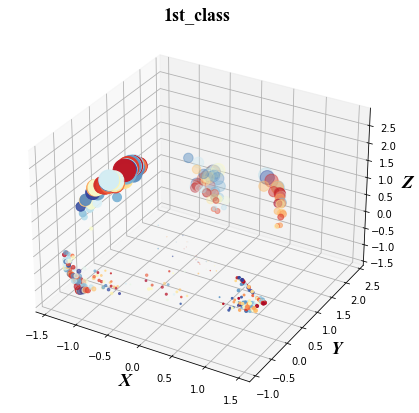

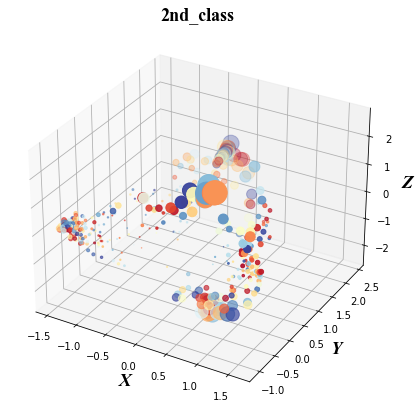

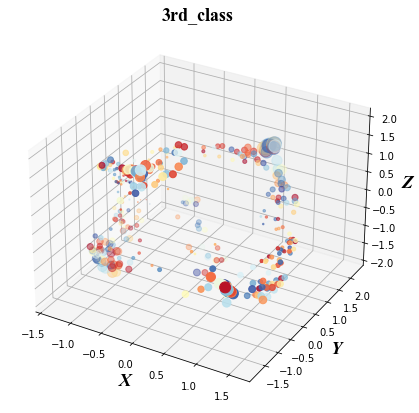

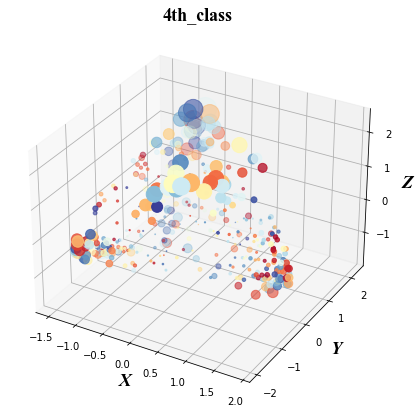

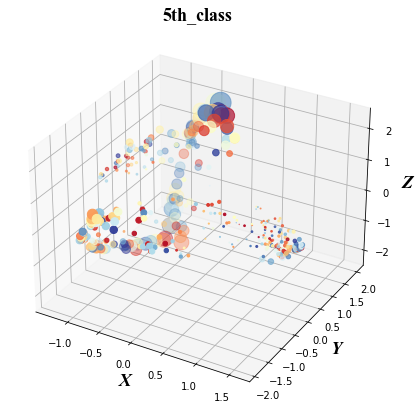

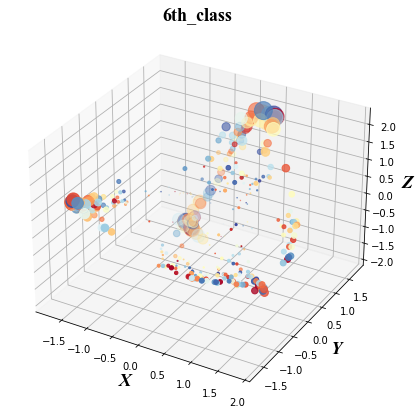

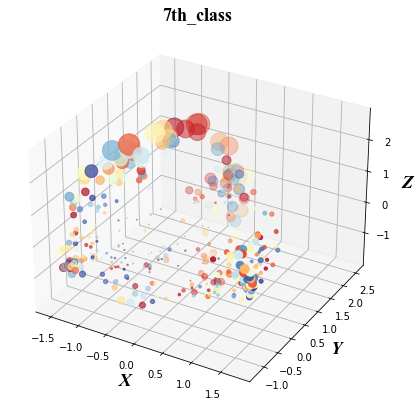

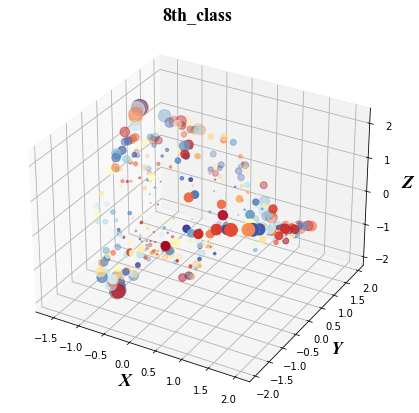

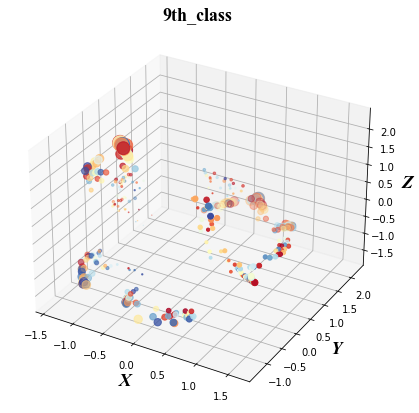

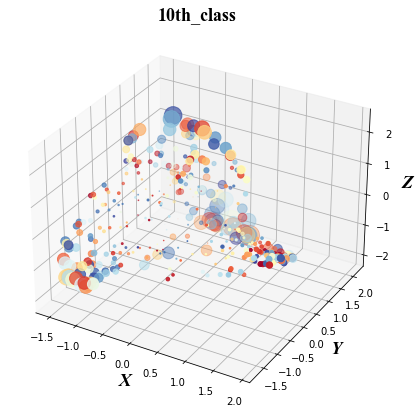

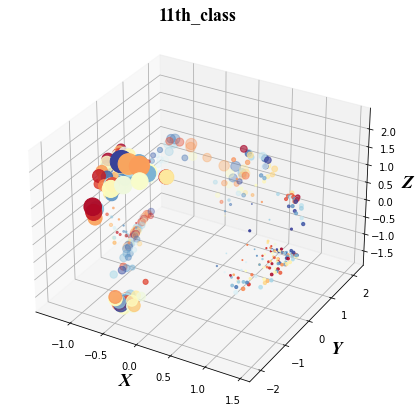

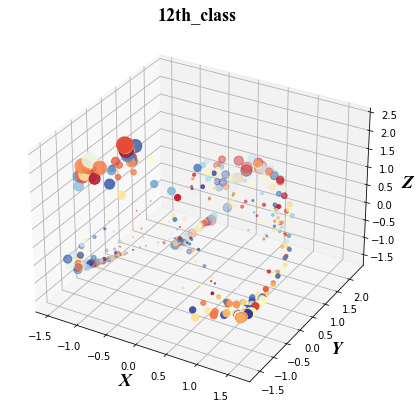

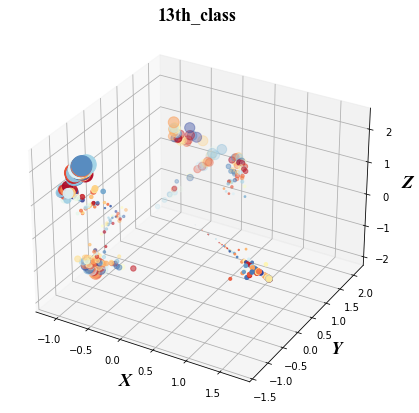

In [14]:
pca = PCA(n_components=3, whiten=True)
font_style = dict(family='Times New Roman', style='italic', size=18, weight='black')
title_style = dict(family='Times New Roman', size=18, weight='black')
for i in range(num_classes):
    outputs = pca.fit_transform(primary_caps_out.outputs[i].detach().numpy()) # (400, 3)
    fig = plt.figure(figsize=(7, 7))
    ax = fig.gca(projection='3d')  # 三维坐标轴
    x = outputs[:, 0]
    y = outputs[:, 1]
    z = outputs[:, 2]
    ax.scatter(x, y, z, s=np.power(np.sqrt(x**2+y**2+z**2), 6), c=np.random.rand(400), cmap=mpl.cm.RdYlBu)
    ax.set_xlabel('X', **font_style)
    ax.set_ylabel('Y', **font_style)
    ax.set_zlabel('Z', **font_style)
    if i == 0:
        plt.title('{}st_class'.format(i+1), **title_style)
    elif i == 1:
        plt.title('{}nd_class'.format(i+1), **title_style)
    elif i == 2:
        plt.title('{}rd_class'.format(i+1), **title_style)
    else:
        plt.title('{}th_class'.format(i+1), **title_style)
    plt.show()
    fig.savefig('./Caps1_Outputs/class_{}.pdf'.format(i+1), bbox_inches='tight')

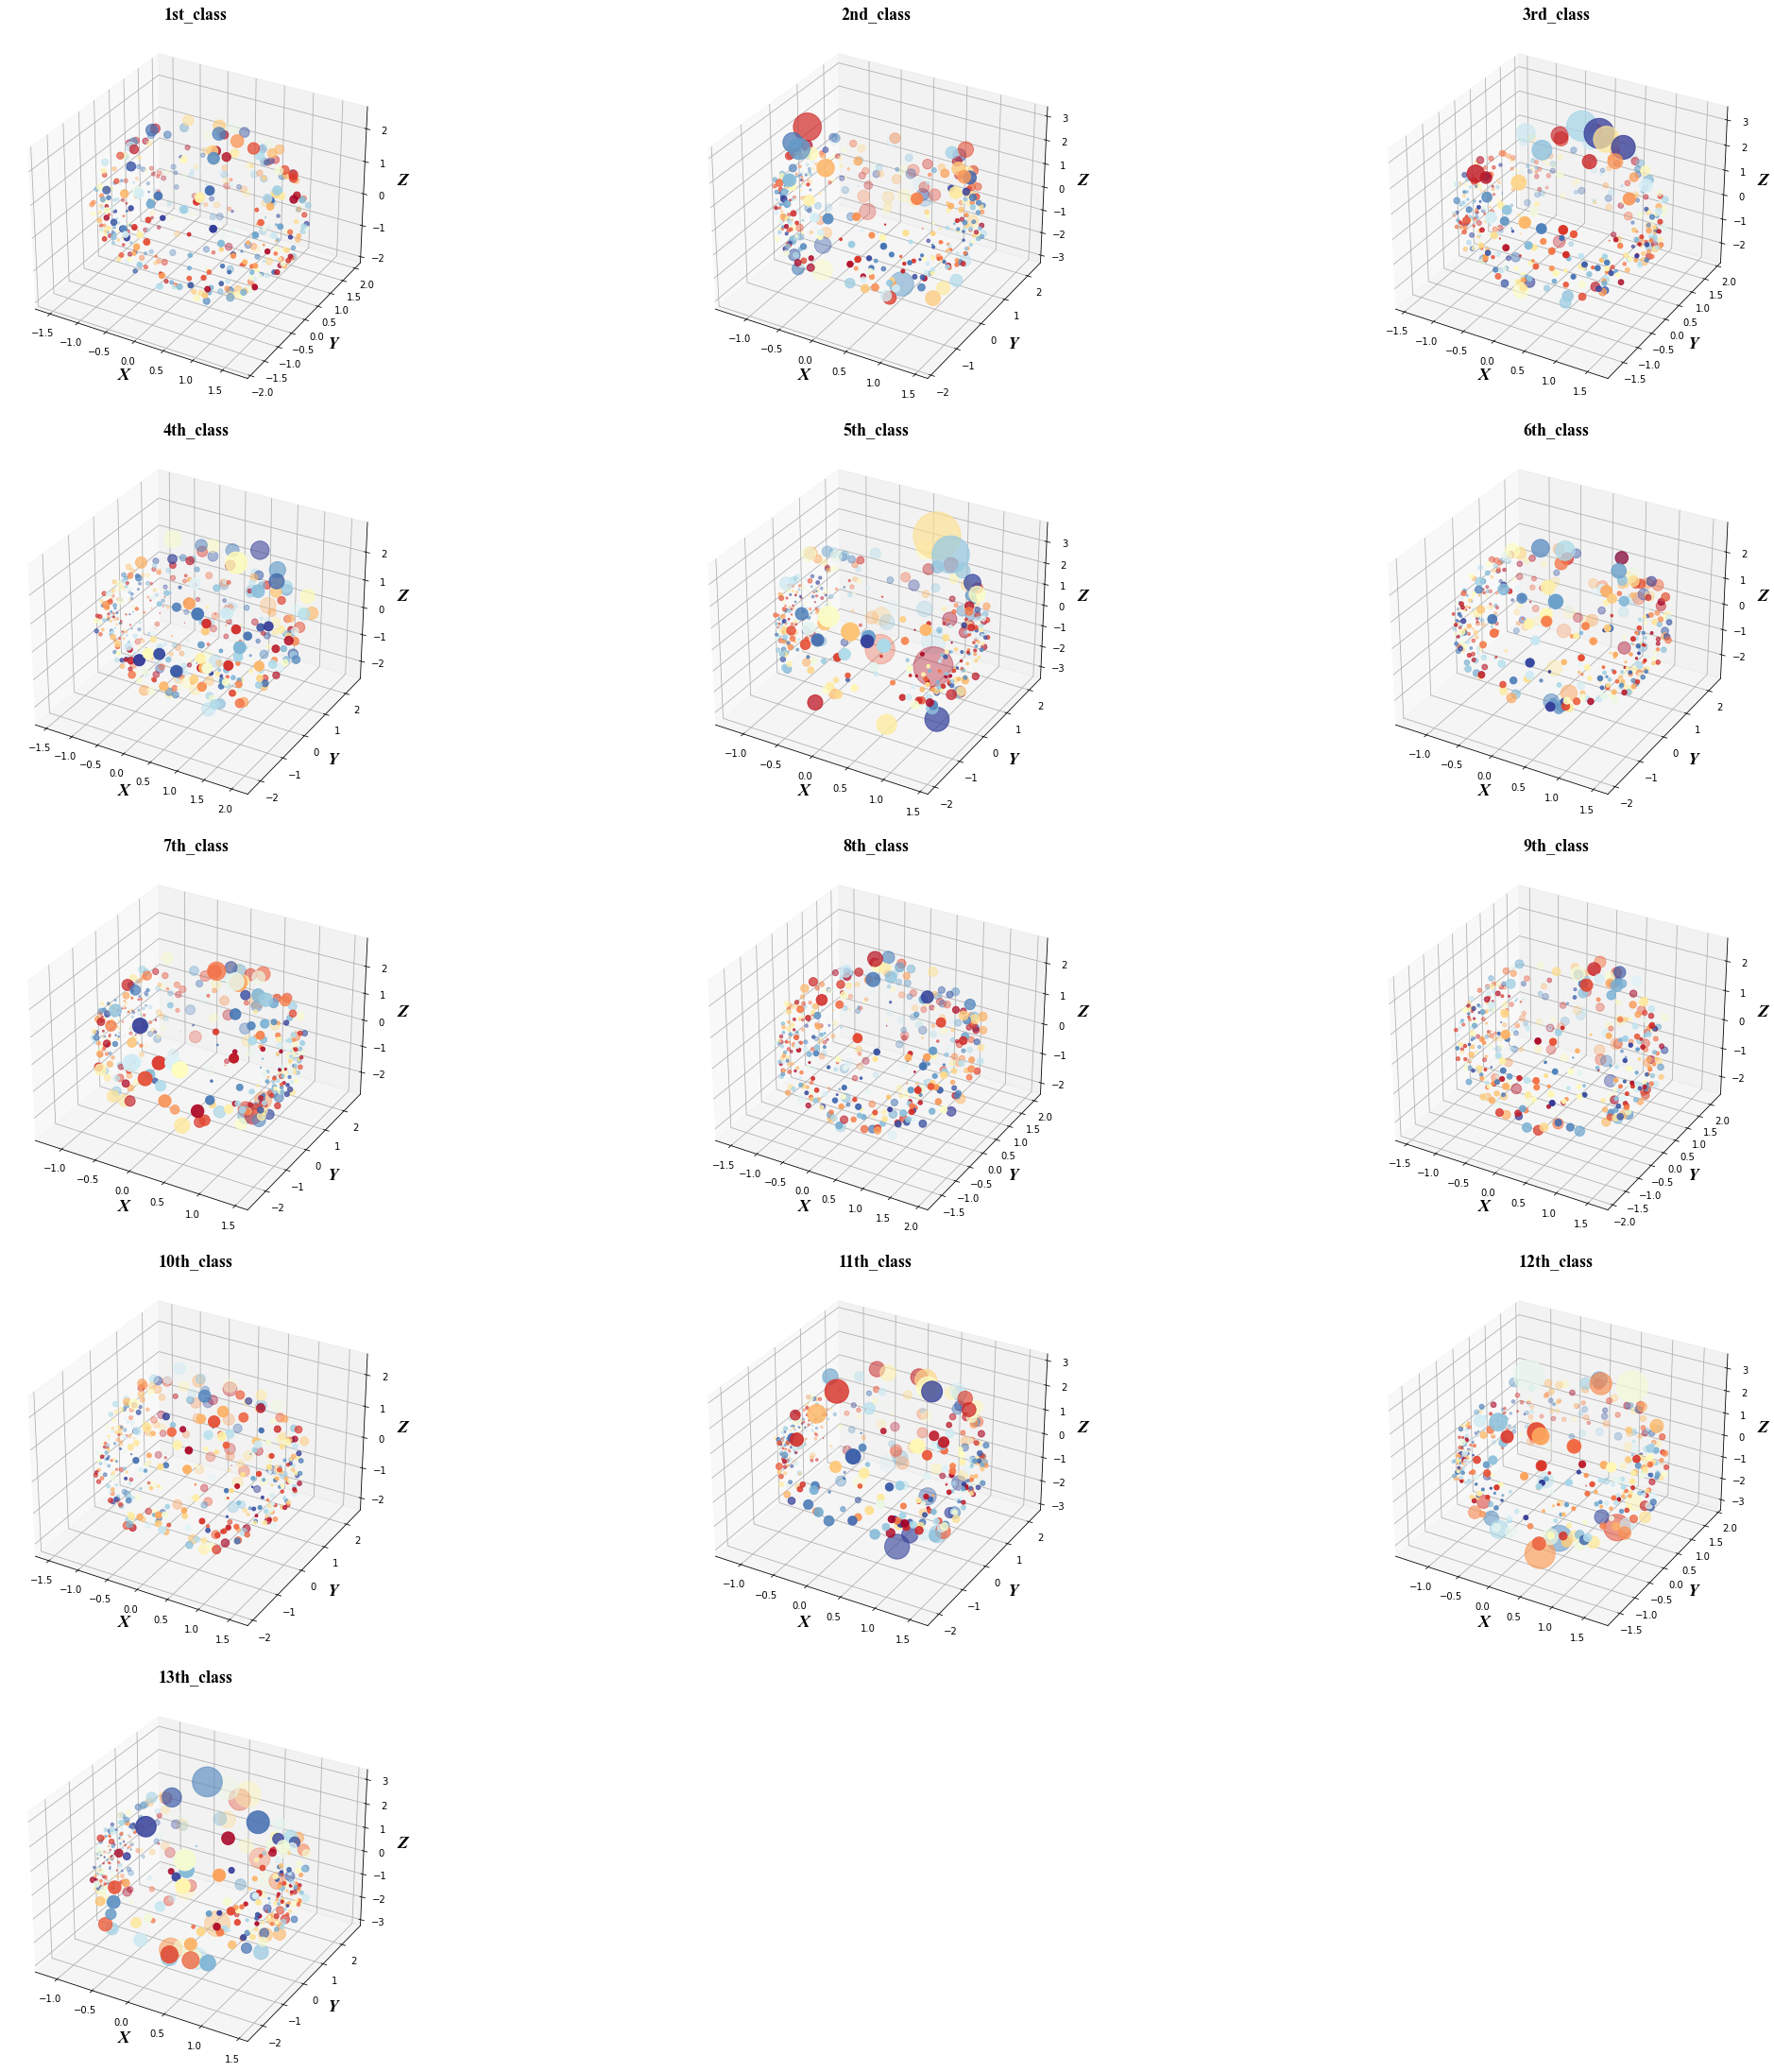

In [15]:
vit_out = ActivationOutputData(model.vit)  # (1, 400, 8)
# 传入测试样本
output, _ = model(x_train.cuda())
vit_out.remove()

font_style = dict(family='Times New Roman', style='italic', size=18, weight='black')
title_style = dict(family='Times New Roman', size=18, weight='black')
fig = plt.figure(figsize=(30, 30))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.1, wspace=0.)
pca = PCA(n_components=3, whiten=True)
for i in range(num_classes):
    outputs = pca.fit_transform(vit_out.outputs[i].detach().numpy())
    ax = fig.add_subplot(5, 3, i+1, projection='3d')
    x = outputs[:, 0]
    y = outputs[:, 1]
    z = outputs[:, 2]
    ax.scatter(x, y, z, s=np.power(np.sqrt(x**2+y**2+z**2), 6), c=np.random.rand(400), cmap=mpl.cm.RdYlBu)
    ax.set_xlabel('X', **font_style)
    ax.set_ylabel('Y', **font_style)
    ax.set_zlabel('Z', **font_style)
    if i == 0:
        plt.title('{}st_class'.format(i+1), **title_style)
    elif i == 1:
        plt.title('{}nd_class'.format(i+1), **title_style)
    elif i == 2:
        plt.title('{}rd_class'.format(i+1), **title_style)
    else:
        plt.title('{}th_class'.format(i+1), **title_style)
        
plt.show()        
fig.savefig('./ViT_Outputs/vit_outputs.pdf', bbox_inches='tight')

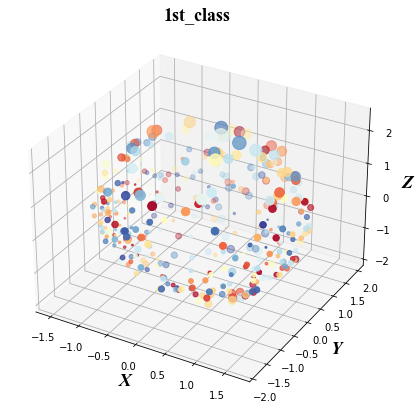

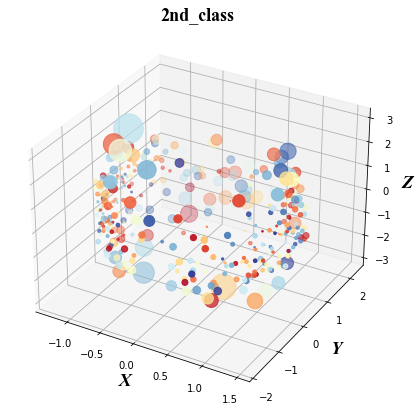

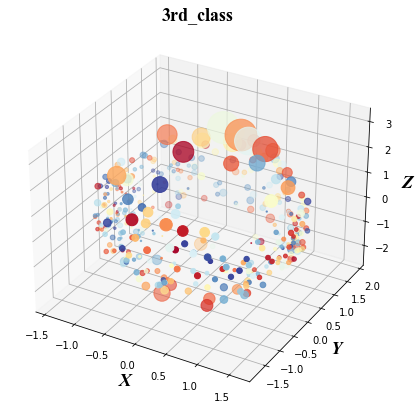

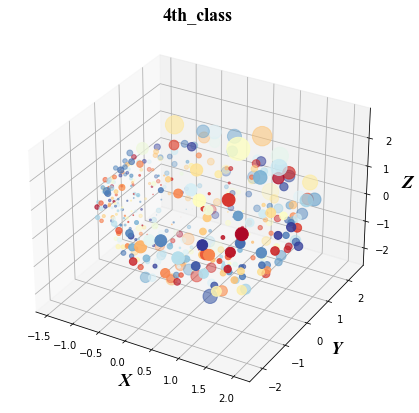

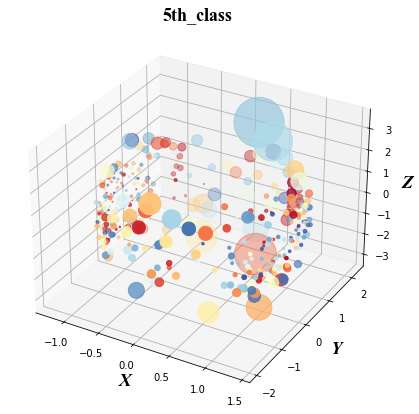

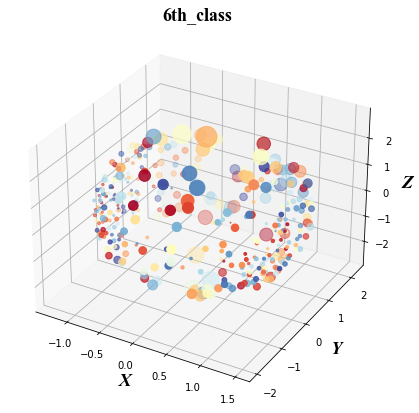

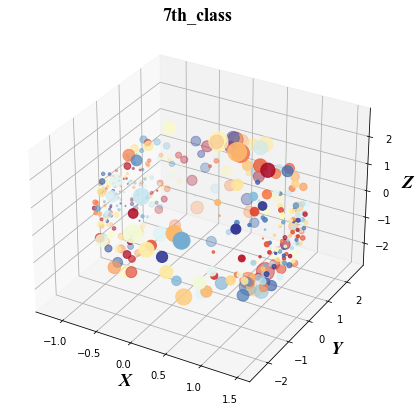

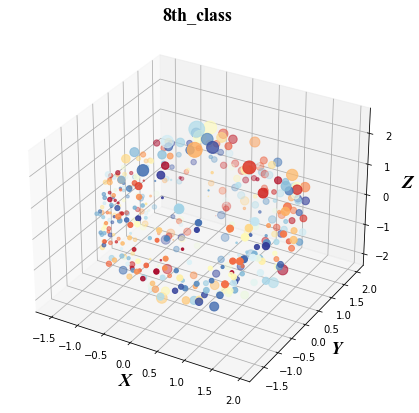

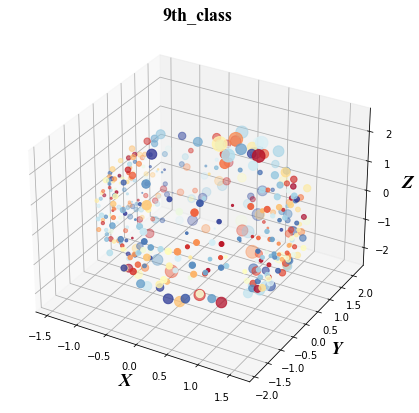

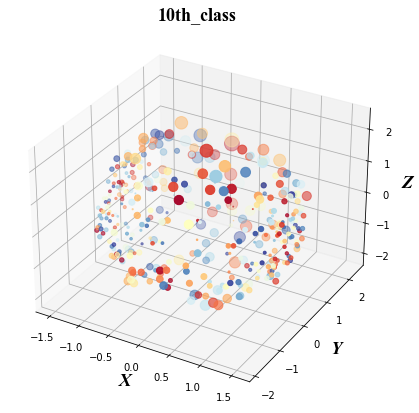

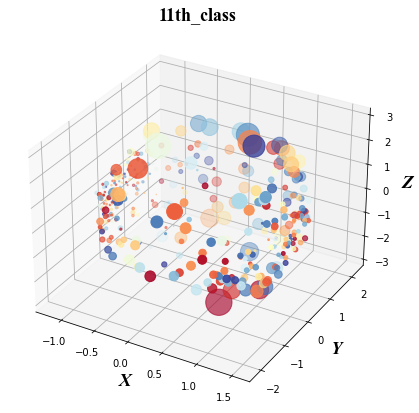

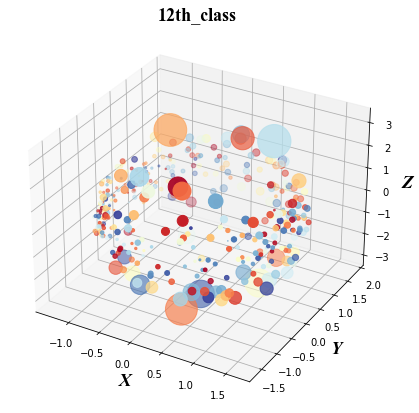

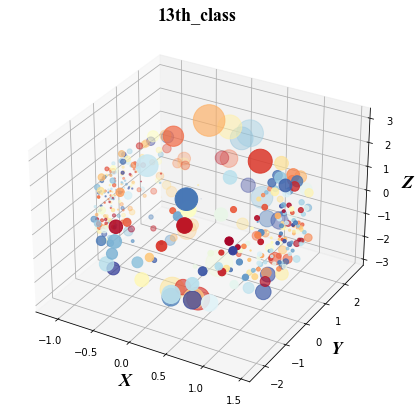

In [16]:
pca = PCA(n_components=3, whiten=True)
font_style = dict(family='Times New Roman', style='italic', size=18, weight='black')
title_style = dict(family='Times New Roman', size=18, weight='black')
for i in range(num_classes):
    outputs = pca.fit_transform(vit_out.outputs[i].detach().numpy()) # (400, 3)
    fig = plt.figure(figsize=(7, 7))
    ax = fig.gca(projection='3d')  # 三维坐标轴
    x = outputs[:, 0]
    y = outputs[:, 1]
    z = outputs[:, 2]
    ax.scatter(x, y, z, s=np.power(np.sqrt(x**2+y**2+z**2), 6), c=np.random.rand(400), cmap=mpl.cm.RdYlBu)
    ax.set_xlabel('X', **font_style)
    ax.set_ylabel('Y', **font_style)
    ax.set_zlabel('Z', **font_style)
    if i == 0:
        plt.title('{}st_class'.format(i+1), **title_style)
    elif i == 1:
        plt.title('{}nd_class'.format(i+1), **title_style)
    elif i == 2:
        plt.title('{}rd_class'.format(i+1), **title_style)
    else:
        plt.title('{}th_class'.format(i+1), **title_style)
    plt.show()
    fig.savefig('./ViT_Outputs/class_{}.pdf'.format(i+1), bbox_inches='tight')

In [19]:
model = CapsViT(band, args.patch_size, preliminary_layer_channels=96, mode=args.mode, caps2_caps=num_classes)

model = model.cuda()
# criterion
criterion = Margin_Recon_Loss().cuda()
# optimizer
optimizer = optim.Adam(model.parameters(), lr=args.learning_rate, weight_decay=args.weight_decay)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=args.gamma)
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=args.epoches//10, gamma=args.gamma)

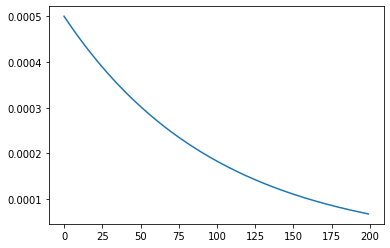

In [20]:
x = np.arange(200)
y = np.array([])
plt.figure()
for epoch in range(200):
    optimizer.step()
    y = np.append(y, scheduler.get_last_lr()[0])
    scheduler.step()

plt.plot(x, y)
plt.show()